# Titanic Dataset Experiment
## Henry Salgado
### May 2025

In [121]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import dice_ml
from dice_ml import Dice
from dice_ml.utils import helpers
from sklearn.ensemble import RandomForestClassifier


Dataset variables can be found here: https://www.kaggle.com/c/titanic/data

In [122]:
import seaborn as sns
df = sns.load_dataset('titanic')
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [123]:
print(df.isnull().sum())

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


In [124]:
df = df.drop(columns=["deck"])
df = df.dropna()



In [125]:
df['sex'].value_counts()

male      453
female    259
Name: sex, dtype: int64

Let's one-hot encode categorical data 

In [126]:
df['sex'] = LabelEncoder().fit_transform(df['sex'])
df['embarked'] = LabelEncoder().fit_transform(df['embarked']) 


In [127]:
df['sex'].value_counts()

1    453
0    259
Name: sex, dtype: int64

In [128]:
X = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]
y = df['survived']

The following correlation table indicates that survival is mostly associated with your class and sex

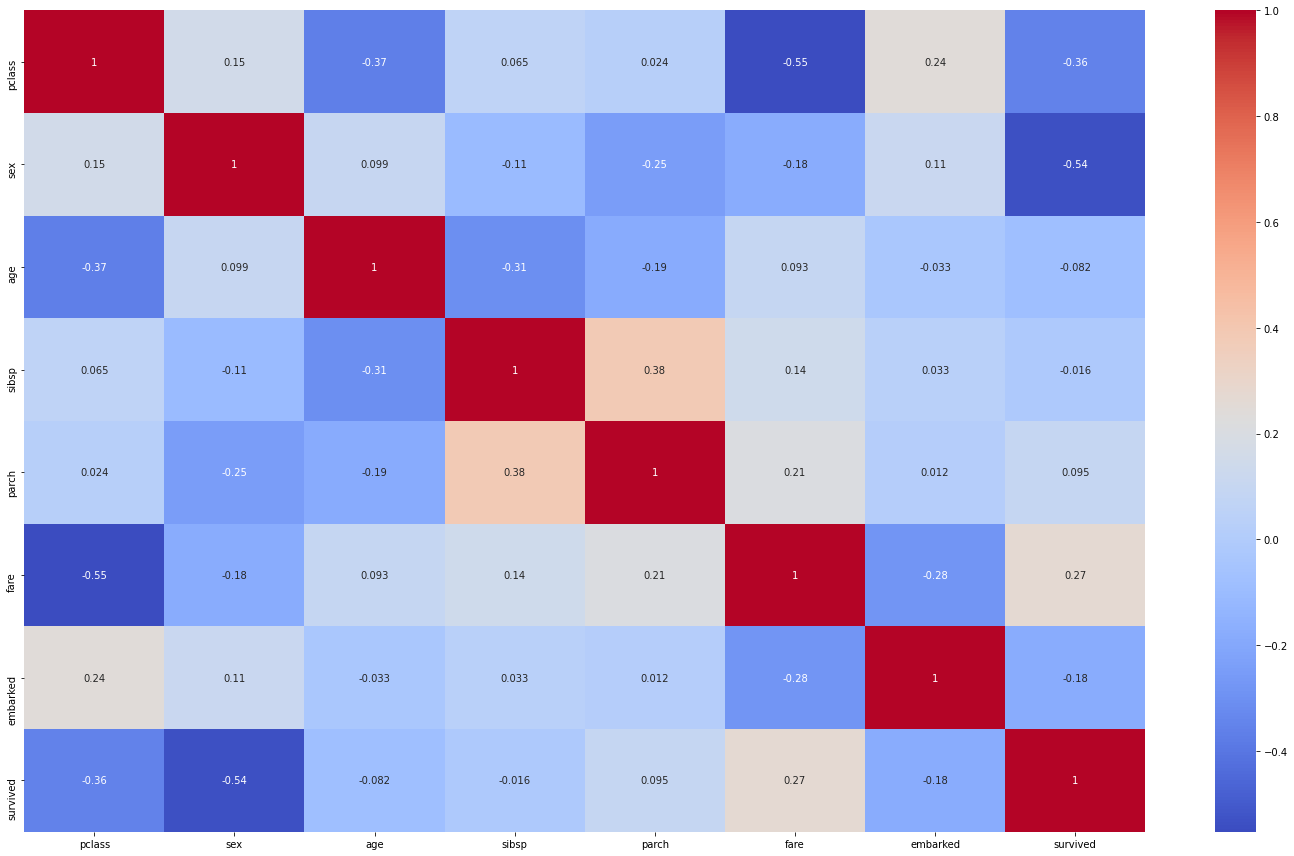

In [129]:
subset = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'survived']]

corr_matrix = subset.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)


In [133]:

class TitanicNN(nn.Module):
    def __init__(self, input_dim):
       super(TitanicNN, self).__init__()
       self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
)

    def forward(self, x):
        return self.net(x)


input_dim = X_train.shape[1]
model = TitanicNN(input_dim)



These two configuration of ANN are arbitrary

In [134]:
class TitanicNN(nn.Module):
    def __init__(self, input_dim):
       super(TitanicNN, self).__init__()
       self.fc1 = nn.Linear(input_dim, 32)
       self.fc2 = nn.Linear(32, 64)
       self.fc3 = nn.ReLU()
       self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)


        return x


input_dim = X_train.shape[1]
model = TitanicNN(input_dim)

In [135]:
# Loss funct 
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [141]:
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Train the model
print("Training the model...")
train_model(model, train_loader, criterion, optimizer, epochs=100)


Training the model...
Epoch [20/100], Loss: 0.3370
Epoch [40/100], Loss: 0.3257
Epoch [60/100], Loss: 0.3195
Epoch [80/100], Loss: 0.3212
Epoch [100/100], Loss: 0.3102


In [157]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        predictions = (torch.sigmoid(outputs) >= 0.5).float()
        correct += (predictions == yb).sum().item()
        total += yb.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 77.62%


In [138]:
background = X_train_tensor[torch.randperm(X_train_tensor.shape[0])[:100]]
background.shape
samples_to_explain = X_test_tensor[:10]
samples_to_explain.shape

torch.Size([10, 7])

Computing SHAP values...
Creating SHAP plots...


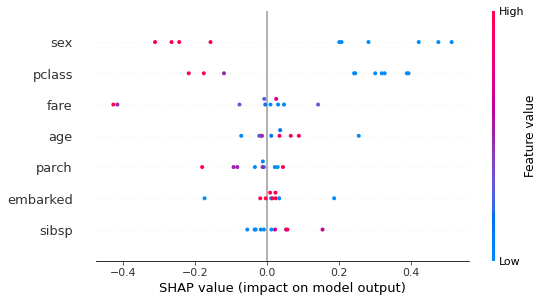

Creating additional SHAP visualizations...
Note: Positive SHAP values = increase survival probability
      Negative SHAP values = decrease survival probability

First sample prediction: Survived (probability: 0.996)
Baseline probability: 0.603


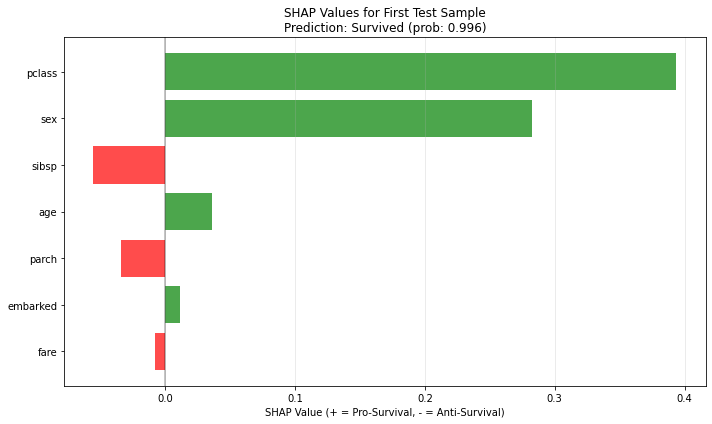

<Figure size 864x288 with 0 Axes>

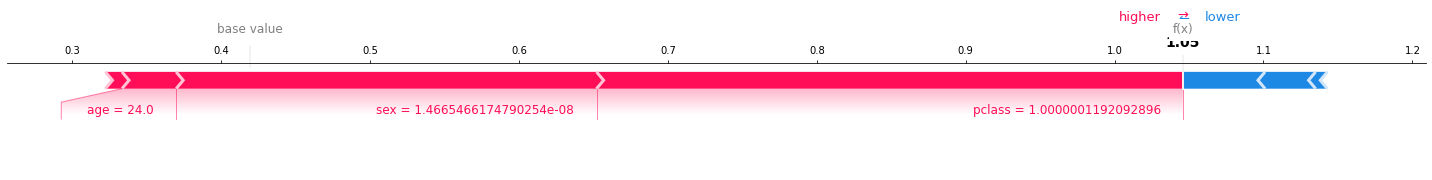


Top 5 Most Important Features for First Sample:
Sample prediction: Survived (probability: 0.996)
1. pclass: 0.3938 (PRO-survival)
   Feature value: 1.0000

2. sex: 0.2823 (PRO-survival)
   Feature value: 0.0000

3. sibsp: -0.0552 (ANTI-survival)
   Feature value: -0.0000

4. age: 0.0364 (PRO-survival)
   Feature value: 24.0000

5. parch: -0.0340 (ANTI-survival)
   Feature value: -0.0000

Evaluating model...
Test Accuracy: 77.62%


77.62237762237763

In [ ]:
import shap

background = X_train_tensor[torch.randperm(X_train_tensor.shape[0])[:100]]
samples_to_explain = X_test_tensor[:10]

class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return torch.sigmoid(self.model(x))  

wrapped_model = WrappedModel(model)
wrapped_model.eval()


print("Computing SHAP values...")
explainer = shap.DeepExplainer(wrapped_model, background)

# Note SHAP values with additivity check disabled (due to BatchNorm)
shap_values = explainer.shap_values(samples_to_explain, check_additivity=False)

if 'feature_names' not in locals():
    feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]


sample_df = pd.DataFrame(
    scaler.inverse_transform(samples_to_explain.detach().numpy()), 
    columns=feature_names
)


print("Creating SHAP plots...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, features=sample_df.values, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()

print("Creating additional SHAP visualizations...")
print("Note: Positive SHAP values = increase survival probability")
print("      Negative SHAP values = decrease survival probability")

# Get prediction for first sample to show context
with torch.no_grad():
    raw_output = model(samples_to_explain[0:1])
    probability = torch.sigmoid(raw_output).item()
    prediction = "Survived" if probability > 0.5 else "Did not survive"

print(f"\nFirst sample prediction: {prediction} (probability: {probability:.3f})")
print(f"Baseline probability: {torch.sigmoid(torch.tensor(explainer.expected_value)).item():.3f}")


plt.figure(figsize=(10, 6))
sample_shap_values = shap_values[0]  
feature_importance = np.abs(sample_shap_values)
sorted_idx = np.argsort(feature_importance)


colors = ['red' if val < 0 else 'green' for val in sample_shap_values[sorted_idx]]

plt.barh(range(len(sorted_idx)), sample_shap_values[sorted_idx], color=colors, alpha=0.7)
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('SHAP Value (+ = Pro-Survival, - = Anti-Survival)')
plt.title(f'SHAP Values for First Test Sample\nPrediction: {prediction} (prob: {probability:.3f})')
plt.grid(axis='x', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()


try:
    plt.figure(figsize=(12, 4))
    shap.force_plot(
        base_value=explainer.expected_value,
        shap_values=shap_values[0], 
        features=sample_df.iloc[0],
        feature_names=feature_names,
        matplotlib=True,
        show=False
    )
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Force plot failed: {e}")


print(f"\nTop 5 Most Important Features for First Sample:")
print(f"Sample prediction: {prediction} (probability: {probability:.3f})")
print("="*60)
sample_shap_values = shap_values[0]
feature_importance = np.abs(sample_shap_values)
top_features_idx = np.argsort(feature_importance)[-5:][::-1]

for i, idx in enumerate(top_features_idx):
    shap_val = sample_shap_values[idx]
    effect = "PRO-survival" if shap_val > 0 else "ANTI-survival"
    print(f"{i+1}. {feature_names[idx]}: {shap_val:.4f} ({effect})")
    print(f"   Feature value: {sample_df.iloc[0, idx]:.4f}")
    print()


def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy


print("Evaluating model...")
evaluate_model(model, test_loader)

This is good accuracy, but we ANNs are black boxes and we can't really see which features are driving the outcome. So, lets try a Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree


In [ ]:
from sklearn.tree import DecisionTreeClassifier


X_train_np = X_train_tensor.numpy()
y_train_np = y_train_tensor.numpy().ravel()
X_test_np = X_test_tensor.numpy()
y_test_np = y_test_tensor.numpy().ravel()


clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train_np, y_train_np)

from sklearn.metrics import classification_report

y_pred = clf.predict(X_test_np)

print(classification_report(y_test_np, y_pred))



              precision    recall  f1-score   support

         0.0       0.70      0.95      0.80        80
         1.0       0.88      0.48      0.62        63

    accuracy                           0.74       143
   macro avg       0.79      0.71      0.71       143
weighted avg       0.78      0.74      0.72       143



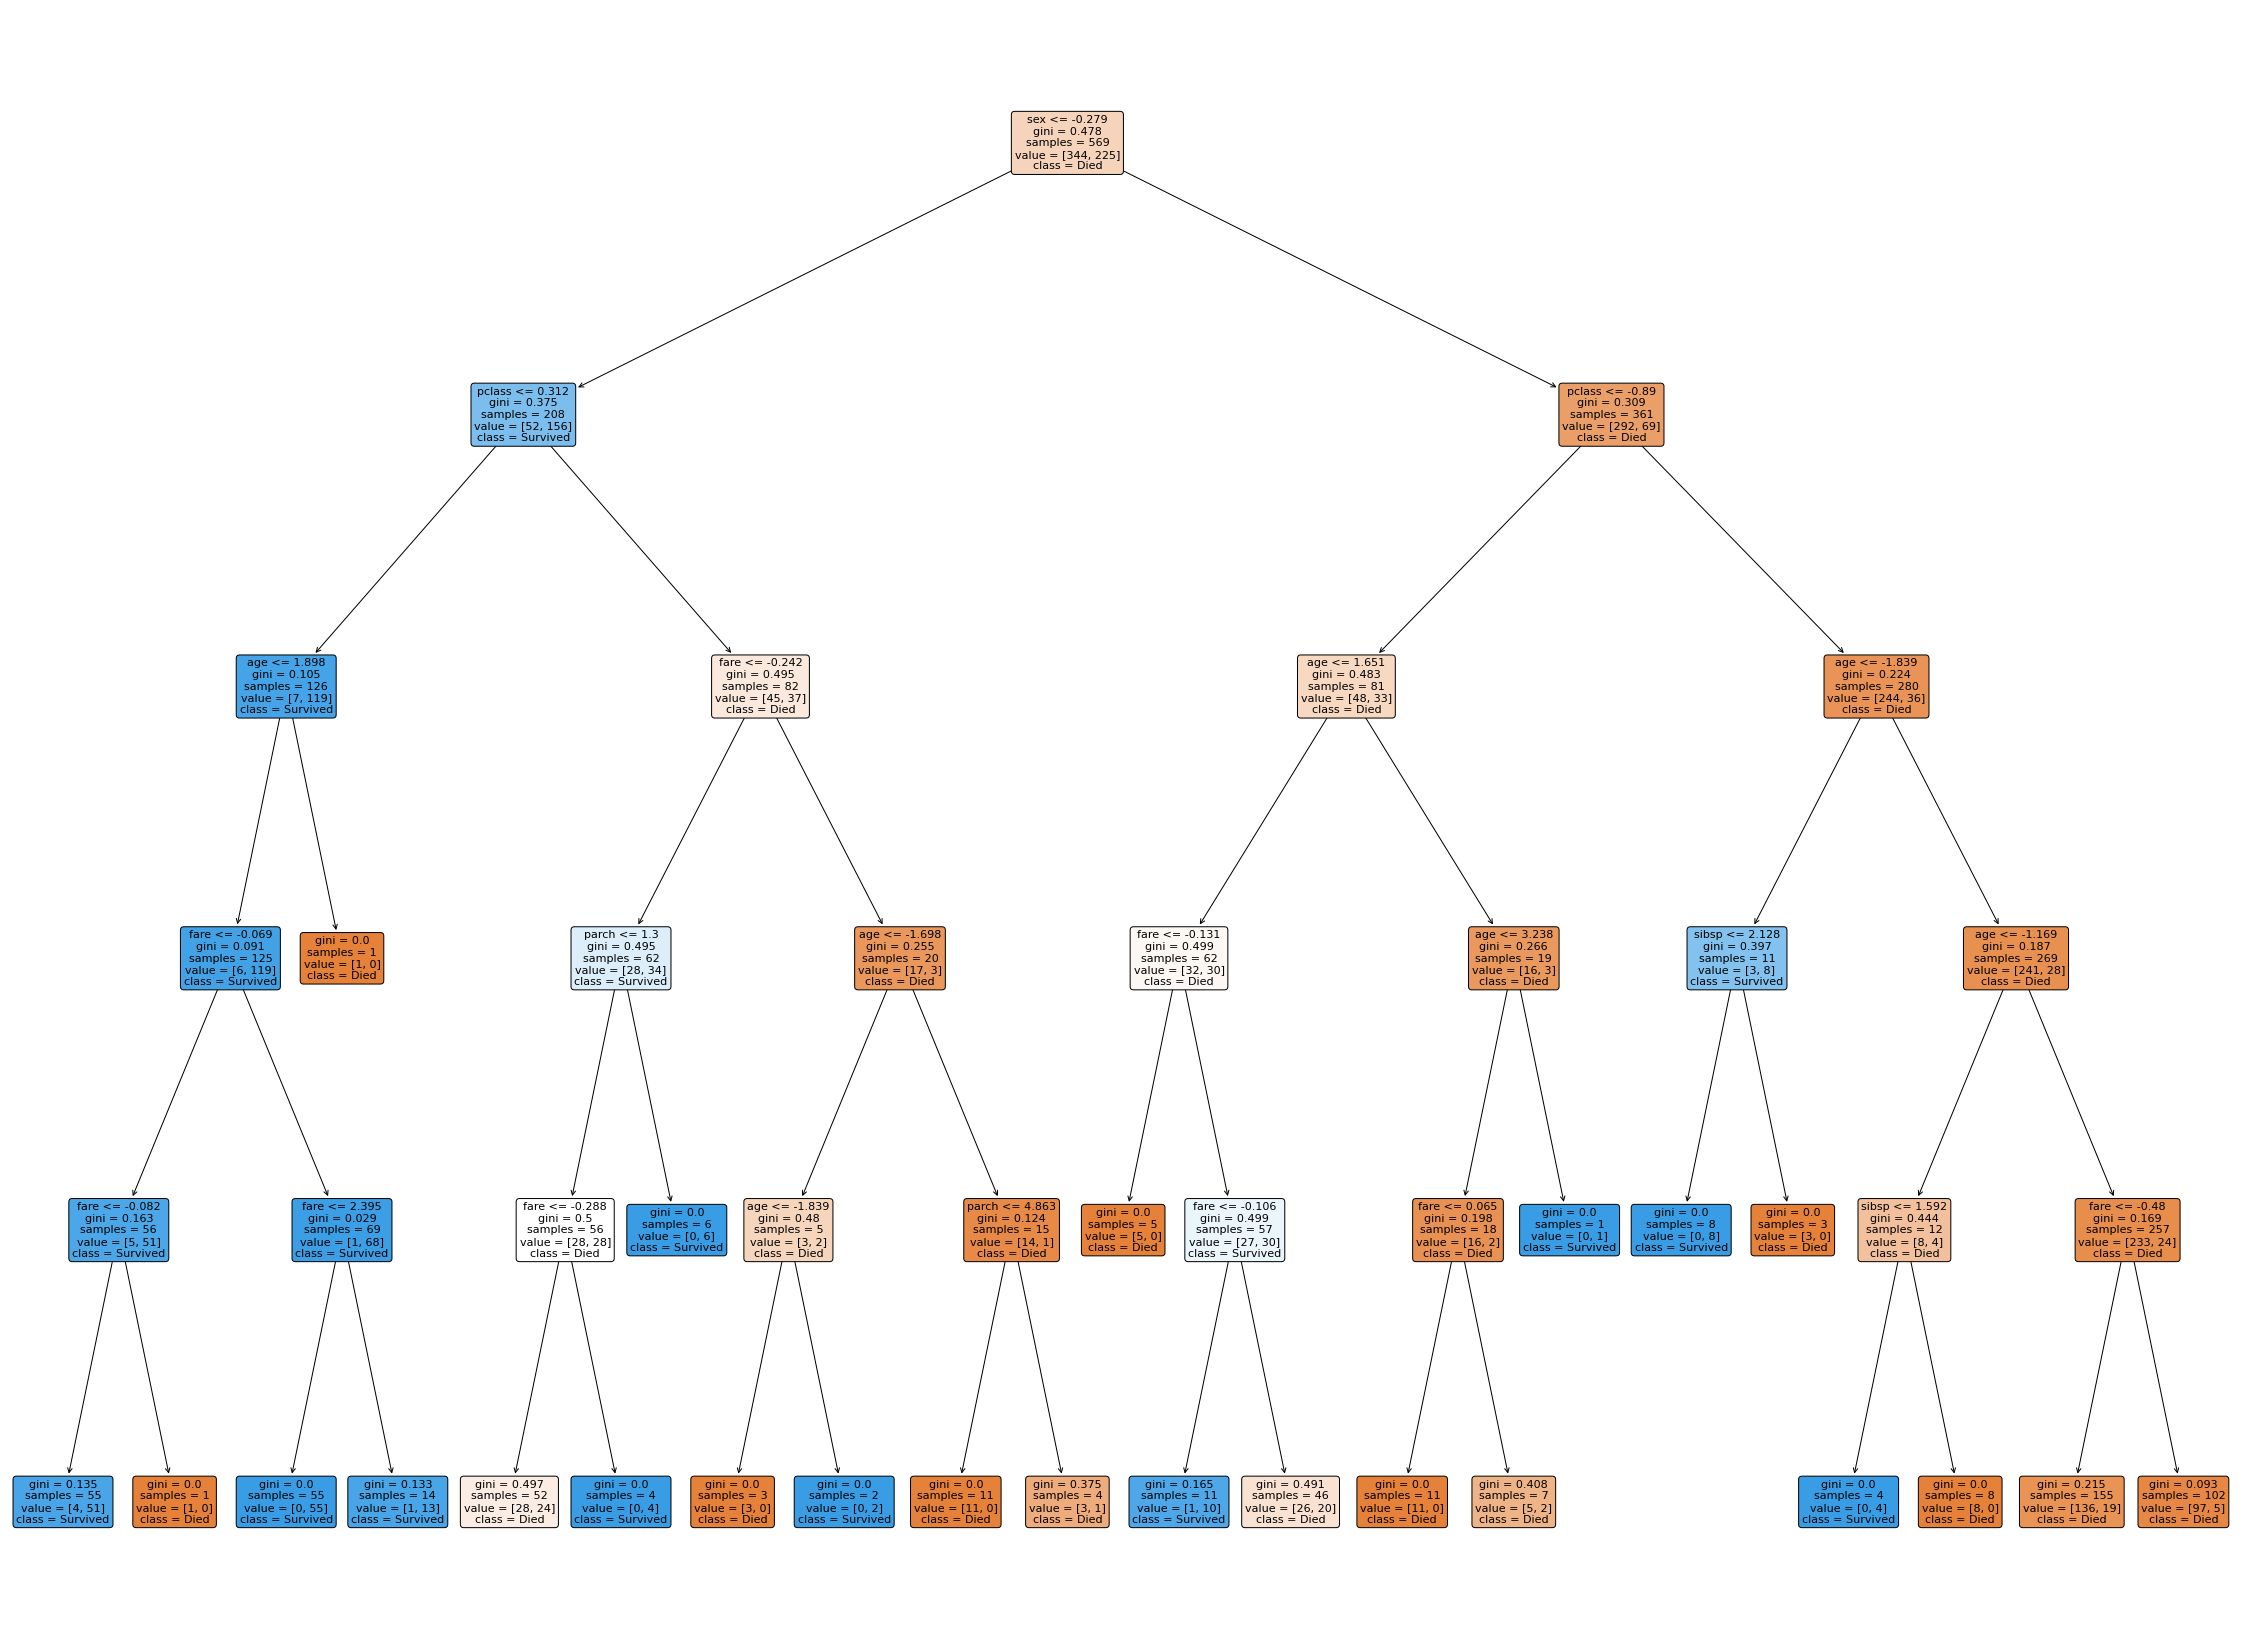

In [ ]:
plt.figure(figsize=(40, 30))
tree.plot_tree(clf, 
               feature_names=['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked'], 
               class_names=['Died', 'Survived'],
               filled=True,
               rounded=True)
plt.show()


    Feature  Importance
1       sex    0.498690
0    pclass    0.205309
2       age    0.115837
5      fare    0.102890
3     sibsp    0.058663
4     parch    0.018611
6  embarked    0.000000


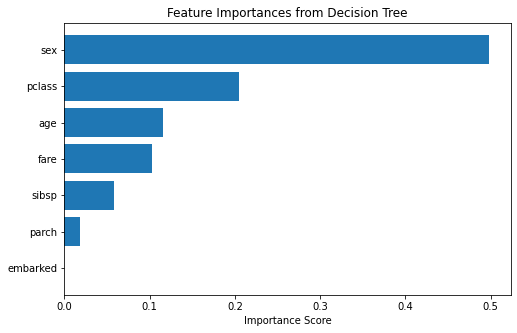

In [ ]:
feature_names = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']


importances = clf.feature_importances_

feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importances)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(feat_importances['Feature'], feat_importances['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importances from Decision Tree')
plt.gca().invert_yaxis()
plt.show()

What about Causal Discovery?

Depth=2, working on node 7: 100%|██████████| 8/8 [00:00<00:00, 633.01it/s] 

PC Algo


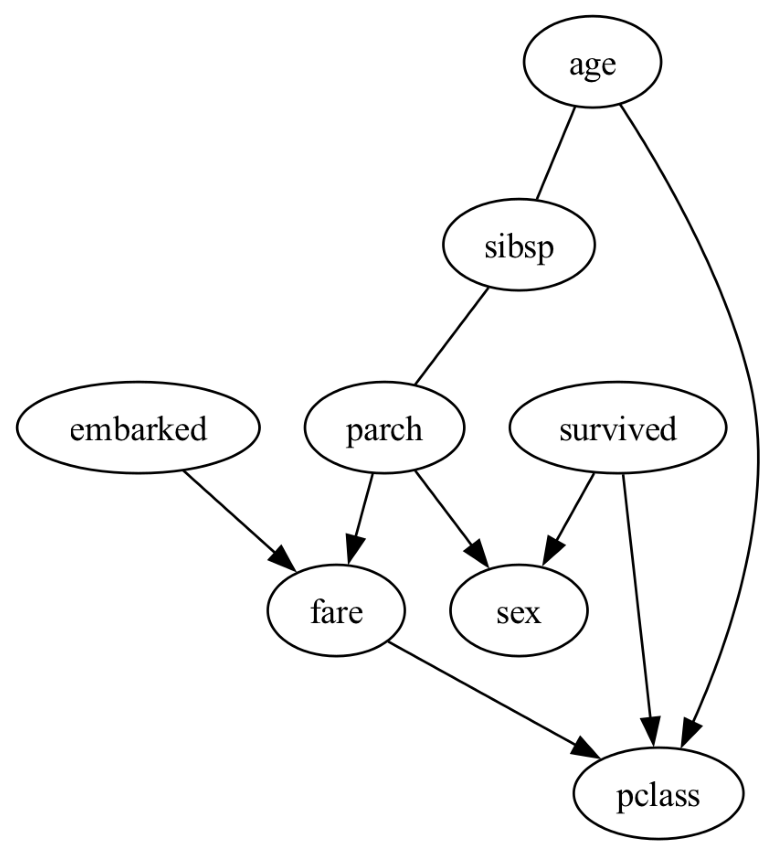

In [ ]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.cit import fisherz, chisq, gsq
import matplotlib.pyplot as plt
from causallearn.utils.GraphUtils import GraphUtils
from IPython.display import Image, display
import pandas as pd

all_features = pd.concat([X, y], axis=1)


X_np = all_features.to_numpy()
col_names = list(all_features.columns)


print("PC Algo")
cg_pc = pc(X_np, alpha=0.01, ci_test=fisherz,  node_names=col_names)


cg_pc.draw_pydot_graph()

In [ ]:
print("_______FCI_______")
cg_fci, sep_set = fci(X_np, alpha=0.05, ci_test=fisherz,  node_names=col_names)
pdy = GraphUtils.to_pydot(cg_fci)
pdy.write_png("fci_graph_titanic.png")

Depth=0, working on node 7: 100%|██████████| 8/8 [00:00<00:00, 489.87it/s]

_______FCI_______
pclass --> fare
sibsp --> age
parch --> sibsp


Can we intervene?

In [ ]:
import pandas as pd
import dice_ml
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder


subset = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'survived']].dropna()
for col in ['sex', 'embarked']:
    subset[col] = LabelEncoder().fit_transform(subset[col])


X = subset.drop('survived', axis=1)
clf = DecisionTreeClassifier(max_depth=4, random_state=42).fit(X, subset['survived'])


dice = dice_ml.Dice(
    dice_ml.Data(dataframe=subset, continuous_features=['age', 'fare'], outcome_name='survived'),
    dice_ml.Model(model=clf, backend="sklearn")
)


query = pd.DataFrame([[3, 0, 22, 1, 0, 7.25, 0]], columns=X.columns)
dice_exp = dice.generate_counterfactuals(
    query, 
    total_CFs=5, 
    desired_class="opposite",
    features_to_vary=['sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
)
dice_exp.visualize_as_dataframe()

100%|██████████| 1/1 [00:00<00:00, 10.62it/s]

Query instance (original outcome : 0)


,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,3,0,22,1,0,7.25,0,0



Diverse Counterfactual set (new outcome: 1)


,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,3,0,14,1,0,7.25,0,1
1,3,0,2,1,3,7.25,0,1
2,3,1,0,1,0,7.25,0,1
3,3,0,6,1,0,7.25,0,1
4,3,0,8,1,0,7.25,0,1


Lets try ARG

In [ ]:
arg_data = df.copy()
arg_data

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone
0,0,3,1,22.0,1,0,7.2500,2,Third,man,True,Southampton,no,False
1,1,1,0,38.0,1,0,71.2833,0,First,woman,False,Cherbourg,yes,False
2,1,3,0,26.0,0,0,7.9250,2,Third,woman,False,Southampton,yes,True
3,1,1,0,35.0,1,0,53.1000,2,First,woman,False,Southampton,yes,False
4,0,3,1,35.0,0,0,8.0500,2,Third,man,True,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,0,39.0,0,5,29.1250,1,Third,woman,False,Queenstown,no,False
886,0,2,1,27.0,0,0,13.0000,2,Second,man,True,Southampton,no,True
887,1,1,0,19.0,0,0,30.0000,2,First,woman,False,Southampton,yes,True
889,1,1,1,26.0,0,0,30.0000,0,First,man,True,Cherbourg,yes,True


Contingency Table (eg Counts)

In [ ]:
pd.crosstab(df['survived'], df['pclass'], normalize='index')


pclass,1,2,3
survived,,,
0,0.150943,0.212264,0.636792
1,0.416667,0.288194,0.295139


Probability of both events occurring together: P(A∩B), all values add up to 1

In [ ]:
joint = pd.crosstab(df['survived'], df['pclass'], normalize=True)
joint


pclass,1,2,3
survived,,,
0,0.089888,0.126404,0.379213
1,0.168539,0.116573,0.119382


Conditional Probability, P(survived = 1 | pclass = 3). Columns add up to 1

In [ ]:
prob = df[(df['survived'] == 1) & (df['pclass'] == 3)].shape[0] / df[df['pclass'] == 3].shape[0]
print(f"P(survived=1 | pclass=3) = {prob:.3f}")


P(survived=1 | pclass=3) = 0.239


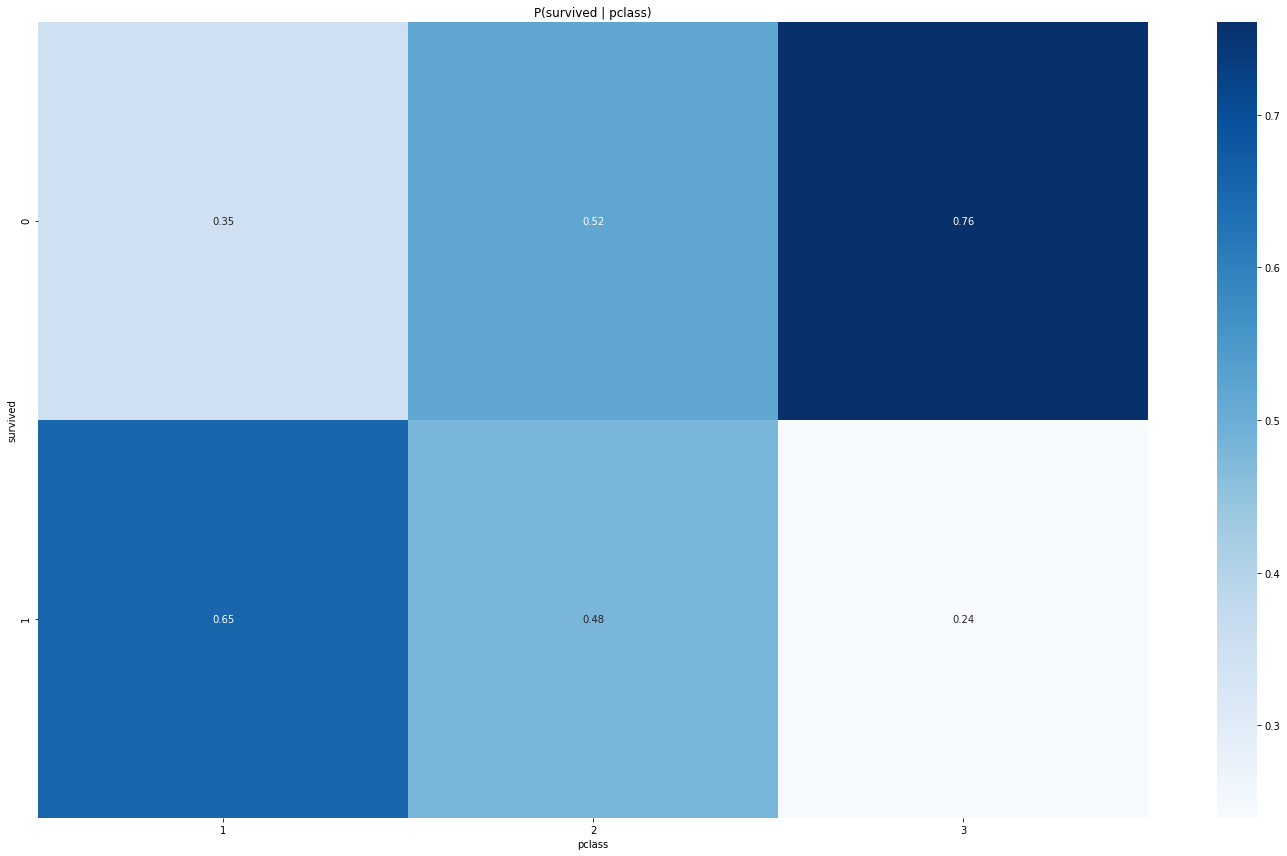

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = pd.crosstab(df['survived'], df['pclass'], normalize='columns')
sns.heatmap(heatmap_data, annot=True, cmap='Blues')
plt.title('P(survived | pclass)')
plt.show()


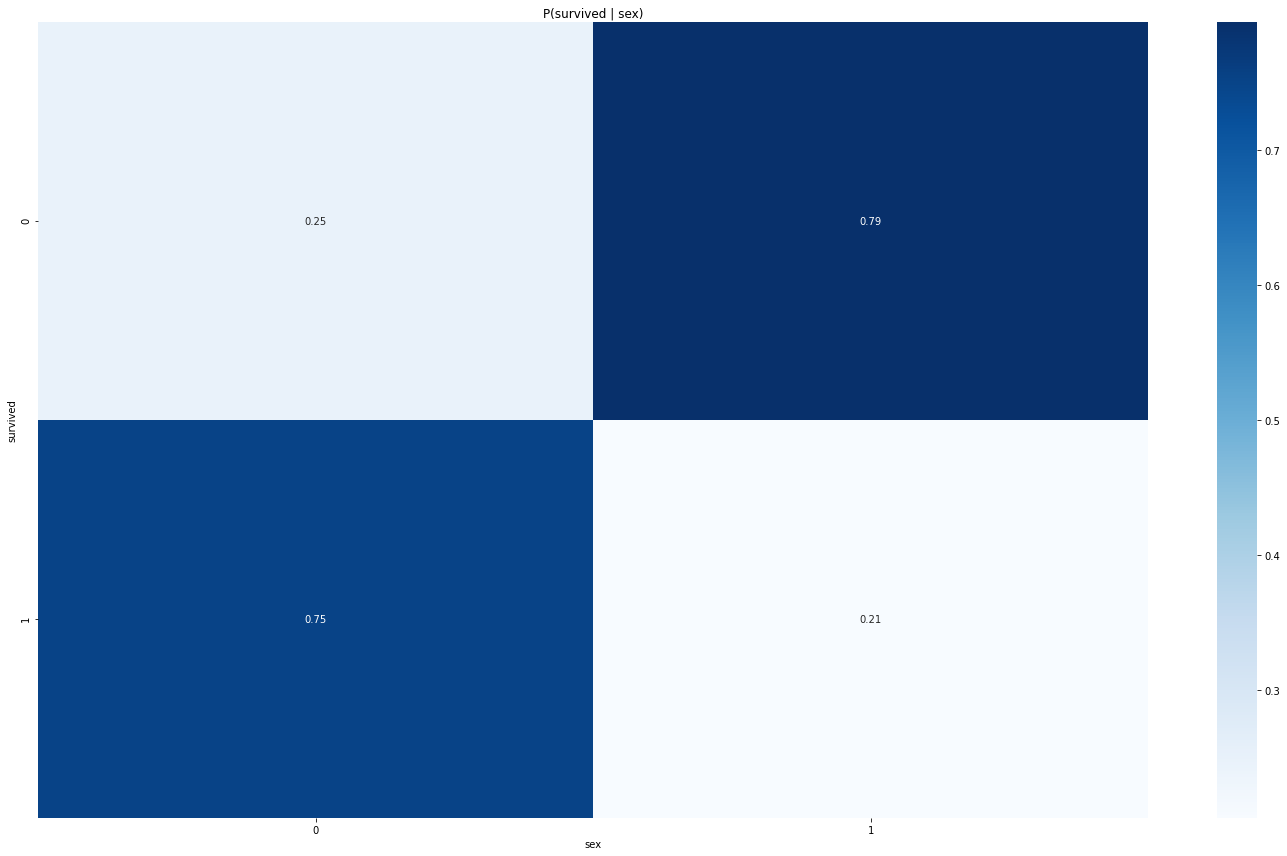

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = pd.crosstab(df['survived'], df['sex'], normalize='columns')
sns.heatmap(heatmap_data, annot=True, cmap='Blues')
plt.title('P(survived | sex)')
plt.show()


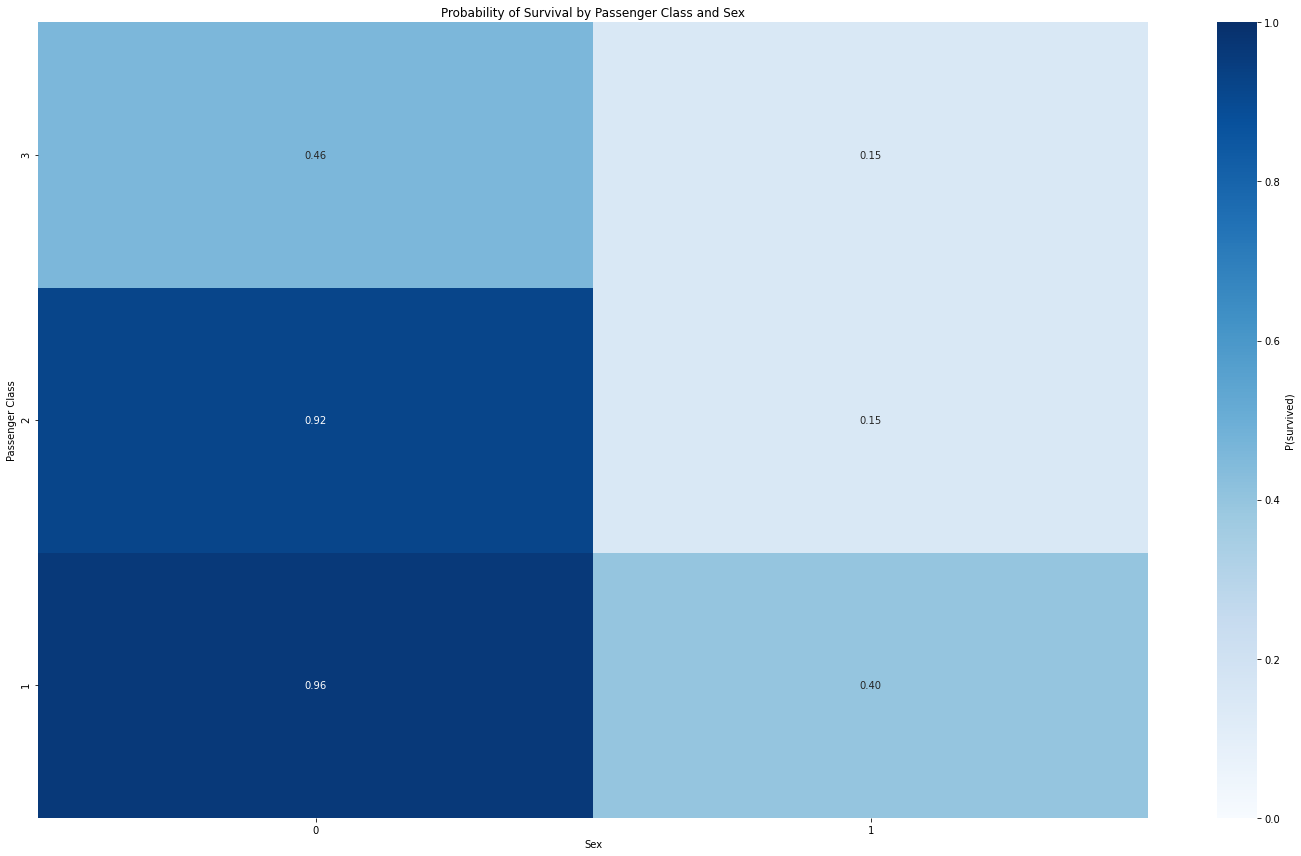

In [159]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = (
    df.pivot_table(index="pclass",
                   columns="sex",
                   values="survived",
                   aggfunc="mean")
      .sort_index(ascending=False)
)

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    vmin=0, vmax=1,
    cbar_kws={"label": "P(survived)"},
)

plt.title("Probability of Survival by Passenger Class and Sex")
plt.ylabel("Passenger Class")
plt.xlabel("Sex")
plt.show()
